<a href="https://colab.research.google.com/github/ioannis-toumpoglou/pytorch-repo/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Datasets

## Domain Libraries

Depending on the problem, whether it is vision, text, audio or recommendation, look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0 and above is required
torch.__version__

'2.0.1+cu118'

In [2]:
# Setup device-agnostic device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

The dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

This dataset starts with 3 classes and only 10% of the images (~75 training, 25 testing).


Why?


When starting a ML project, it is important to try things out on a small scale and then gradually increase the scale, when necessary.

The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup a path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f'{image_path} directory already exists... Skipping download')
else:
  print(f'{image_path} directory doesn\'t exist... Creating directory')
  image_path.mkdir(parents=True,
                   exist_ok=True)
  
# Download data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as file:
  request = requests.get(url='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print(f'Downloading the dataset...')
  file.write(request.content)

# Unzip the downloaded file
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping the dataset file...')
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory doesn't exist... Creating directory
Unzipping the dataset file...


## 2. Becoming one with the data (data preparation and exploration)

In [4]:
import os

def walk_through_dir(dir_path):
  """
    Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.


In [6]:
# Setup training and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Write code to:
1. Get all image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name
4. Open the image with Python PIL
5. Show image and print metadata

Random image path: data/pizza_steak_sushi/test/pizza/540882.jpg
Image class: pizza
Image height: 384
Image width: 512


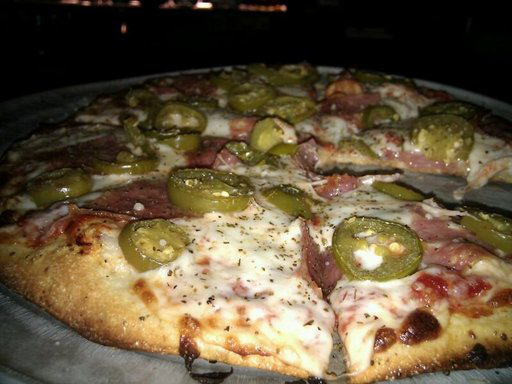

In [10]:
import random
from PIL import Image

# Set seed
torch.manual_seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Show image and print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')

img

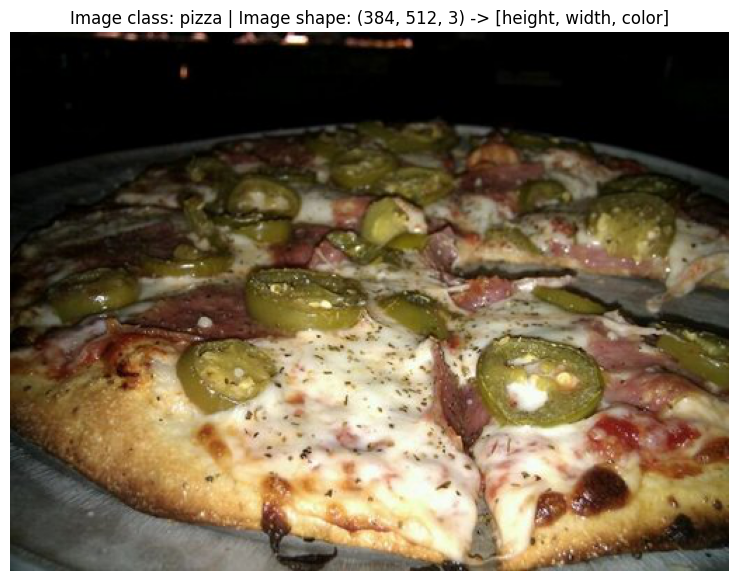

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color]')
plt.axis(False);

In [12]:
img_as_array

array([[[ 2,  2,  2],
        [ 2,  2,  2],
        [ 1,  1,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 1,  1,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[47, 63, 62],
        [49, 65, 64],
        [53, 67, 67],
        ...,
        [46, 55, 50],
        [45, 54, 49],
        [45, 54, 49]],

       [[44, 60, 59],
        [47, 63, 62],
        [51, 67, 66],
        ...,
        [43, 54, 48],
        [42, 53, 47],
        [42, 53, 47]],

       [[36, 52, 51],
        [40, 56, 55],
        [45, 61, 60],
        ...,
        [43, 54, 48],
        [42, 53, 47],
        [42, 53, 47]]], dtype=uint8)

## 3. Transforming data

Before using an image with PyTorch:
1. Turn the target data into tensors
2. Turn the target data into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms helps getting the images ready to be used with a model/platform data augmentation

In [14]:
# Write a transform form image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=[64, 64]),
    # Flip the images randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a tensor
    transforms.ToTensor()
])

In [16]:
data_transform(img)

tensor([[[0.0039, 0.0039, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1569, 0.1686, 0.1804,  ..., 0.2196, 0.2157, 0.2353],
         [0.2078, 0.2078, 0.1882,  ..., 0.2980, 0.2510, 0.2588],
         [0.2275, 0.2667, 0.2471,  ..., 0.2784, 0.2196, 0.1961]],

        [[0.0039, 0.0039, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1765, 0.1804, 0.1922,  ..., 0.2314, 0.2353, 0.2588],
         [0.2431, 0.2353, 0.2039,  ..., 0.3451, 0.3020, 0.3098],
         [0.2784, 0.3137, 0.2824,  ..., 0.3098, 0.2510, 0.2275]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [17]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [18]:
data_transform(img).dtype

torch.float32

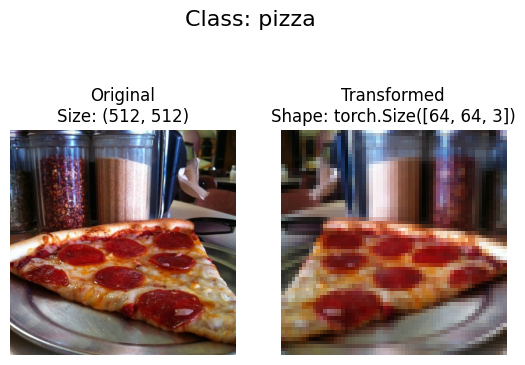

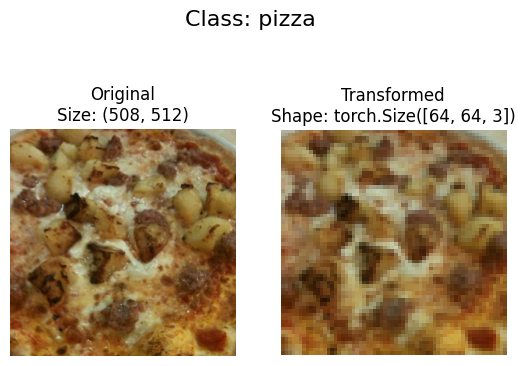

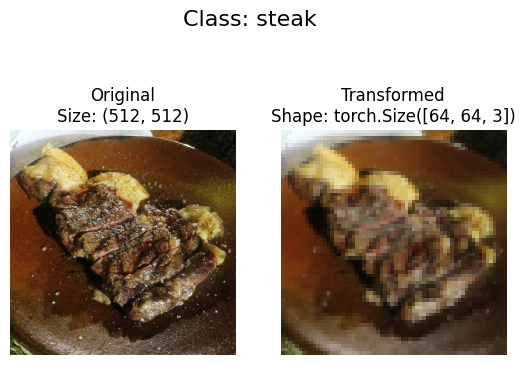

In [29]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
    Selects random images, loads/transforms them and plots the original vs transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, axis = plt.subplots(nrows=1, ncols=2)
      axis[0].imshow(f)
      axis[0].set_title(f'Original\nSize: {f.size}')
      axis[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)  # need to change shape for matplotlib (C, H , W) -> (H, W, C)
      axis[1].imshow(transformed_image)
      axis[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      axis[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

Image classification data can be loaded using `torchvision.datasets.ImageFolder`

In [30]:
# Use ImageFolder to create datasets
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,   # a transform for the data
                                  target_transform=None)    # a teansform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [32]:
# Get class names as a list
class_names = train_data.class_to_idx
class_names

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [33]:
len(train_data), len(test_data)

(225, 75)

In [34]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)